# for making panels b and c in supplemental figure 6 metapredict V3 manuscript

In [15]:
import os
import metapredict as meta
import numpy as np
import matplotlib
import math
import matplotlib.pyplot as plt
import random
from matplotlib.pyplot import figure
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve
from scipy.stats import norm, gaussian_kde
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'
# set fonts
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

# set colors for plots here. Colors are for V1, v2, and v3. Chosen because Ryan can differentiate them.
v1color='#FF9D33'
v2color='#FF6433'
v3color='#CC2D46'
hybridcolor='black'
pLDDT_color='blue'


# Figure 6 B

In [3]:
# functions to help with graphing points and spreading them out on the scatterplot.
def generate_uniformly_spaced_points(min_val, max_val, num_points):
    """
    Generates a specified number of uniformly spaced points between a minimum and maximum value.

    Parameters:
    min_val (float): The minimum value.
    max_val (float): The maximum value.
    num_points (int): The number of uniformly spaced points to generate.

    Returns:
    list of floats: The uniformly spaced points.
    """
    if num_points < 2:
        raise ValueError("num_points must be at least 2 to generate a range of points.")
    
    step = (max_val - min_val) / (num_points - 1)
    return [min_val + i * step for i in range(num_points)]
    
def jitter_based_on_density(y_coords, grouping_by=0.01, min_val=0, max_val=0.5, base_jitter=0.15):
    """
    Jitters x positions of data points based on the density of nearby points.

    Parameters:
    y_coords (list of floats): The y coordinates of the data points.

    Returns:
    list of tuples: The data points with jittered x positions.
    """
    # sort the data
    data=sorted(y_coords)
    groups=[]
    center=min_val+((max_val-min_val)/2)
    total_vals=len(y_coords)
    for i in np.arange(min(y_coords)-grouping_by, max(y_coords)+(grouping_by*3), grouping_by):
        i=round(float(i),5)
        totpoints=len([a for a in y_coords if a >=i and a<round(i+grouping_by, 5)])
        if totpoints!=0:
            if totpoints==1:
                groups.extend([center])
            else:
                plus_minus=(totpoints/total_vals)/2
                if totpoints <= 4:
                    curvals=generate_uniformly_spaced_points(center-plus_minus, center+plus_minus, totpoints)
                elif totpoints >4 and totpoints < 10:
                    curvals=generate_uniformly_spaced_points(center-(plus_minus+(base_jitter/2)), center+(plus_minus+(base_jitter/2)), totpoints)
                else:
                    curvals=generate_uniformly_spaced_points(center-(plus_minus+(base_jitter)), center+(plus_minus+(base_jitter)), totpoints)
                random.shuffle(curvals)
                groups.extend(curvals)
    return[data, groups]
        
        

In [4]:
# add ability to figure out viral proteoems with single proteins if we want to
# read in the viral counts so we can exclude things with a single protein
viruses_by_count={}
with open(f'viral_proteome_id_to_count.tsv') as fh:
    l=fh.read().split('\n')[1:]
    for sl in l:
        if l != '':
            splitvals=sl.split('\t')
            if splitvals != []:
                name=splitvals[0]
                if name != '':
                    count=int(splitvals[-1])
                    viruses_by_count[name]=count

# load viral lineages
viruses={}
with open(f'viruses_w_lineage.tsv') as fh:
    l=fh.read().split('\n')[1:]
    for sl in l:
        if l != '':
            splitvals=sl.split('\t')
            if splitvals != []:
                name=splitvals[0]
                lineage=splitvals[-1]
                if lineage!=['']: 
                    viruses[name]=lineage


# get viral identifiers that have single gene
single_gene_virus=[]
for v in viruses_by_count:
    if viruses_by_count[v]==1:
        single_gene_virus.append(v)
print(len(single_gene_virus))

814


In [5]:
# loading in data
# SET WHETHER TO REMOVE VIRAL GENOMES WITH ONE GENE! These do add a lot of noise to the graph...
remove_single_gene_proteome=True


# get disorder
vir_dis_dict={}
with open(f'viral_proteome_fraction_disorder_by_prot_and_total_proteome.tsv') as fh:
    lines=fh.read().split('\n')
    for l in lines[1:]:
        if l != '':
            splitvals=l.split('\t')
            if splitvals != []:
                if remove_single_gene_proteome:
                    if splitvals[0] not in single_gene_virus:
                        vir_dis_dict[splitvals[0]]={'per_protein':float(splitvals[1]), 'total_proteome':float(splitvals[2])}
                else:
                    vir_dis_dict[splitvals[0]]={'per_protein':float(splitvals[1]), 'total_proteome':float(splitvals[2])}


In [6]:
# function to break down into subgroups and filter with a min per group
def break_down_into_groups(groups, min_per_group=5, vals='per_protein'):
    '''
    Returns a dictionary of the groups with over min_per_group
    fractions of disorder for graphing. 
    '''
    if vals not in ['total_proteome', 'per_protein']:
        raise Exception('vals must be total_proteome or per_protein')
    lineages=viruses
    disorder=vir_dis_dict
    
    # holds empty list for each group
    group_dict={}
    for p in groups:
        group_dict[p]=[]
    
    allv=[]
    for a in lineages:
        lineage=lineages[a]
        splitvals=lineage.split(', ')
        t=[]
        for k in splitvals:
            t.append(k.lower())
        for v in groups:
            if v.lower() in t:
                if a in disorder.keys():
                    group_dict[v].append(disorder[a][vals])
    
    # get rid of stuff without min val
    find={}
    for v in group_dict:
        if len(group_dict[v])>=min_per_group:
            find[v]=group_dict[v]
    return find

In [7]:
# function for graphing
def graph_lineages(group_disorder_dict, title=None, figsize=[4.5,4.5], shade=[], save='', ylabel='',
                  marker='.', s=3, alpha=0.2):
    fig, total=plt.subplots(ncols=1, nrows=1, figsize=figsize, dpi=150, facecolor='w', edgecolor='k')
    maxval=len(group_disorder_dict)
    for n, p in enumerate(group_disorder_dict): 
        #plot per protein
        data=jitter_based_on_density(group_disorder_dict[p], min_val=n, max_val=n)
        total.scatter(data[1], data[0], marker=marker, s=s, alpha=alpha)
        avg=np.mean(data[0])
        total.plot([n-0.2, n+0.2], [avg,avg], color='black', linewidth=1)
        if title!=None:
            total.set_title(title, fontsize=9)
    total.set_xticks([a for a in range(0, len(group_disorder_dict.keys()))], list(group_disorder_dict.keys()), rotation=90)
    nc=0
    colors=['blue', 'green', 'yellow', 'red']
    if shade!=[]:
        for v in shade:
            if nc==0:
                start=v[0]-0.75#/maxval
            else:
                start=v[0]-0.5
            stop=v[1]-0.5#/maxval
            total.axvspan(start, stop, zorder=0, alpha=0.03, color=colors[nc])
            nc+=1
    total.set_xlim([-0.5, maxval-0.25])
    total.set_ylabel(ylabel)
    if save=='':
        plt.show()
    else:
        plt.tight_layout()
        plt.savefig(save)


In [8]:
# get list of viral groups after 'viruses'. will be familiy or unclassified / environmental sample
viral_groups=[]
for v in viruses:
    viral_lineage=viruses[v]
    if viral_lineage!='':
        viral_lineage.replace(' ', '')
        viral_lineage=viral_lineage.split(',')
        if viral_lineage[0]=='Viruses':
            group=viral_lineage[1][1:]
            viral_groups.append(group)
# make a set
viral_groups=list(set(viral_groups))
print(viral_groups)

['Thaspiviridae', 'Duplodnaviria', 'Monodnaviria', 'Varidnaviria', 'Guttaviridae', 'unclassified viruses', 'Plasmaviridae', 'Dinodnavirus', 'Adnaviria', 'Tolecusatellitidae', 'Halspiviridae', 'Anelloviridae', 'unclassified bacterial viruses', 'unclassified archaeal viruses', 'Spiraviridae', 'Alphasatellitidae', 'Satellites', 'Clavaviridae', 'Polydnaviriformidae', 'Ampullaviridae', 'environmental samples', 'Ovaliviridae', 'Ribozyviria', 'Fuselloviridae', 'Riboviria', 'Portogloboviridae', 'Bicaudaviridae', 'Naldaviricetes', 'Globuloviridae']


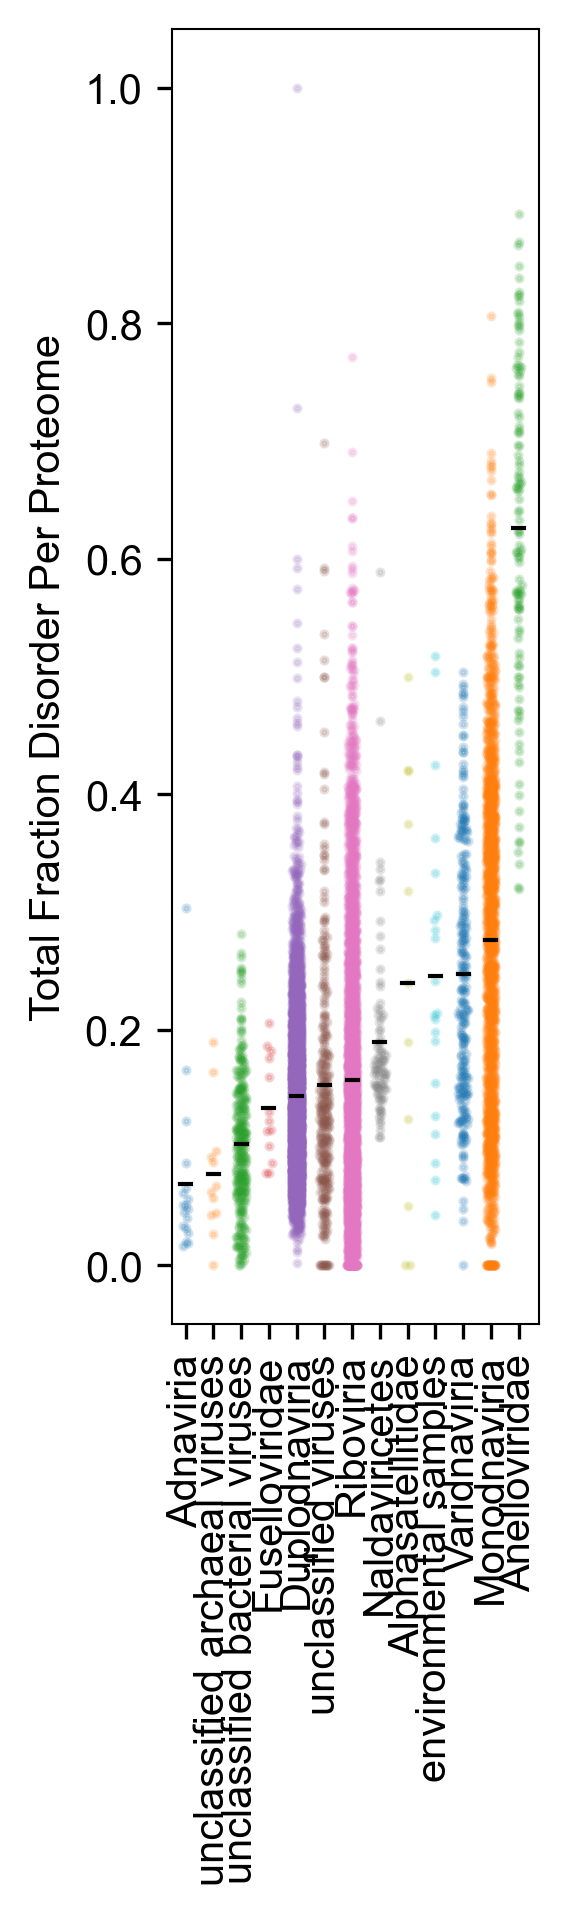

In [10]:
# set min number per group. If anything is less than this, it won't be includedd. 
min_per_group=10

# set as per protein or total proteome. 
# 'per_protein' is the average fraction of disorder per protein across a protome.
# 'total_proteome' is the number of residues that are predicted to be disordered in a proteome
# divide by the total number of residues in the proteome. This accounts for the length of each
# protein in the proteome.

disorder_vals='total_proteome'

if disorder_vals=='per_protein':
    # AFPP = Average fraction per protein across the proteome.
    graph_tag='AFPP'
    ylabel='Average Fraction Disorder Per Protein Per Proteome'
elif disorder_vals=='total_proteome':
    # TFAP = Total fraction across proteome
    graph_tag='TFAP'
    ylabel='Total Fraction Disorder Per Proteome'

# check if we got rid of single gene proteoems. 
if remove_single_gene_proteome==True:
    save_tag='no_single_gene_proteomes'
else:
    save_tag='include_single_gene_proteomes'
    

# set groups to graph
graph_groups=break_down_into_groups(viral_groups,  min_per_group=min_per_group)
# get average values for each group
average_disorder_by_group={}
for i in graph_groups.keys():
    average_val=sum(graph_groups[i])/len(graph_groups[i])
    average_disorder_by_group[i]=average_val
# sort by values
average_disorder_by_group_sorted = dict(sorted(average_disorder_by_group.items(), key=lambda item: item[1]))
# now pull out 'non family' names and pin to end. 
final_groups=[]

for f in average_disorder_by_group_sorted:
    final_groups.append(f)

# now get disorder in the order we want
graph_values=break_down_into_groups(final_groups)

# finally graph them and save fig
graph_lineages(graph_values,ylabel=ylabel,
               save=f'Fig6B_{graph_tag}_min_{min_per_group}_per_group_{save_tag}.pdf', 
               figsize=[2,6.5], s=8, alpha=0.2)

# Figure 6C

In [16]:

# read in data.
def read_in_tsv(path_to_tsv):
    per_protein=[]
    total_proteome=[]
    with open(path_to_tsv) as fh:
        lines=fh.read().split('\n')
    fh.close()
    for l in lines[1:]:
        if l != '':
            if len (l.split('\t'))==3:
                vals=l.split('\t')
                per_protein.append(float(vals[1]))
                total_proteome.append(float(vals[2]))
    return {'per_protein':per_protein, 'total_proteome':total_proteome}


archaea_infecting=read_in_tsv('archaeal_infecting_viruses.tsv')
bacteria_infecting=read_in_tsv('bacterial_infecting_viruses.tsv')
eukaryotic_infecting=read_in_tsv('eukaryotic_infecting_viruses.tsv')
human_infecting=read_in_tsv('human_infecting_viruses.tsv')
ecoli_infecting=read_in_tsv('ecoli_infecting_viruses.tsv')

In [17]:
# functions to help with graphing points and spreading them out on the scatterplot.    
def generate_density_based_scatter_data(y_values, center=0, base_width=1.0, scale_factor=2.0, abs_range=0.3):
    """
    Generates X values for a scatter plot where denser areas on the Y-axis are spread wider on the X-axis.
    
    Parameters:
    y_values (list or array): Input Y values.
    center (float): The center of the X-axis distribution (default: 0).
    base_width (float): Base width of the X distribution for the sparsest areas (default: 1.0).
    scale_factor (float): Factor to scale the X width based on local density (default: 2.0).
    abs_range (float) : absolute range +/- the center a value can be
    Returns:
    tuple: X and Y values to plot.
    """
    # Calculate the density of Y values using a Gaussian KDE
    kde = gaussian_kde(y_values)
    
    # Evaluate the density for each Y value
    density = kde(y_values)
    
    # Normalize density to [0, 1] range to scale the X-axis width
    density_normalized = (density - density.min()) / (density.max() - density.min())
    
    # Generate X values based on the local density of Y values
    x_spread = base_width + scale_factor * density_normalized
    x_values = np.random.normal(loc=center, scale=x_spread, size=len(y_values))
    
    
    return x_values, y_values


In [18]:
#combine archaea and bacteria int prokaryotes
per_protein=[]
total_proteome=[]
for i in archaea_infecting['per_protein']:
    per_protein.append(i)
for i in bacteria_infecting['per_protein']:
    per_protein.append(i)
for i in archaea_infecting['total_proteome']:
    total_proteome.append(i)
for i in bacteria_infecting['total_proteome']:
    total_proteome.append(i)  
prokaryote_infecting={'total_proteome':total_proteome, 'per_protein':per_protein}

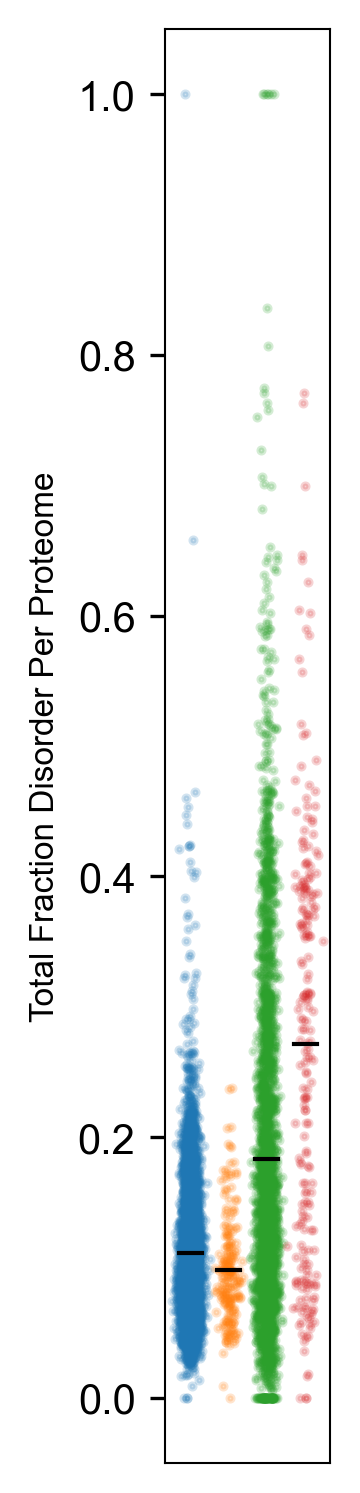

In [19]:
# set per protein or total proteome
disorder_vals='total_proteome'

if disorder_vals=='per_protein':
    # AFPP = Average fraction per protein across the proteome.
    graph_tag='AFPP'
    ylabel='Average Fraction Disorder Per Protein Per Proteome'
elif disorder_vals=='total_proteome':
    # TFAP = Total fraction across proteome
    graph_tag='TFAP'
    ylabel='Total Fraction Disorder Per Proteome'

proteomes={'Prokaryote infecting':prokaryote_infecting, 'E. coli infecting':ecoli_infecting,
           'Eukaryote infecting': eukaryotic_infecting, 'H. sapiens infecting':human_infecting}
fig, per_prot=plt.subplots(ncols=1, nrows=1, figsize=(1.3, 5.08), dpi=150, facecolor='w', edgecolor='k')
for n, p in enumerate(proteomes): 
    x_values, y_values=generate_density_based_scatter_data(proteomes[p][disorder_vals], 
                                                           center=n, base_width=0.1, scale_factor=0.05)
    per_prot.scatter(x_values, y_values, marker='.', s=8, alpha=0.2)
    avg=np.mean(y_values)
    per_prot.plot([n-0.3, n+0.3], [avg,avg], color='black', linewidth=1)

#per_prot.set_xticks([a for a in range(0, len(proteomes.keys()))], 
#                    list(proteomes.keys()), rotation=90, linespacing=0.7)
per_prot.set_xticks([])
per_prot.set_ylabel(ylabel, fontsize=8)
plt.tight_layout()
plt.savefig(f'Supplemental_Fig_6C_{graph_tag}.pdf')